## Decision Tree from scratch

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

In [ ]:
data=pd.read_csv('Q1Data.csv')
data.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_9,MFCCs_10,...,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,Family,Genus,Species
0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,0.188654,...,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre
1,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,0.270958,...,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre
2,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,0.266064,...,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre
3,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,0.267279,...,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre
4,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,0.332695,...,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre


In [ ]:
#independent and dependent features
X = data.iloc[:,:6].values
y = data.iloc[:,22].values.reshape(-1, 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.8, random_state=42)

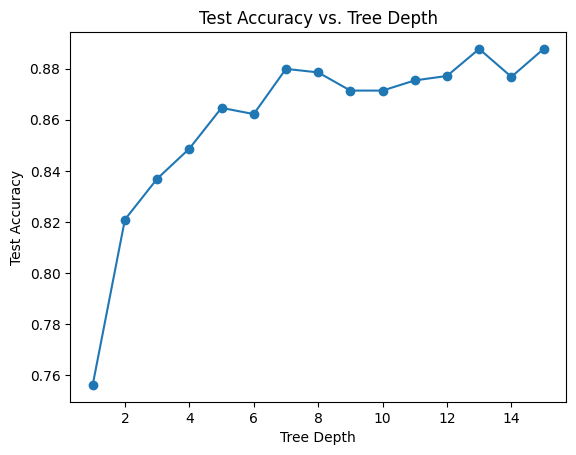

In [ ]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        # Internal node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        # Leaf node using majority voting
        self.value = value

class DecisionTree():
    def __init__(self, min_samples_split, max_depth):
        self.root = None
        #hyperparameters
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)

        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)

            if best_split["gini_index"] < float("inf"): #prevents overfitting
                lst = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                rst = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                return Node(best_split["feature_index"], best_split["threshold"],
                            lst, rst, best_split["gini_index"])

        lvalue = self.calculate_leaf_value(Y)
        return Node(value=lvalue)

    def get_best_split(self, dataset, num_samples, num_features):
        best_split = {
            "feature_index": None,
            "threshold": None,
            "dataset_left": None,
            "dataset_right": None,
            "gini_index": float("inf")
        }

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            unique_values = np.unique(feature_values)#to avoid travelling the whole dataset and just the unique values

            # Adjust sample_size if the number of unique values is less than 10
            sample_size = min(10, len(unique_values))
            possible_thresholds = np.random.choice(unique_values, size=sample_size, replace=False)

            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_gini_index = self.gini_index(y, left_y, right_y)
                    if curr_gini_index < best_split["gini_index"]:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["gini_index"] = curr_gini_index

        return best_split


    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])#met our condition
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right

    def gini_index(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        gini = 1.0 - (weight_l * self.gini_impurity(l_child) + weight_r * self.gini_impurity(r_child))
        return gini

    def gini_impurity(self, y):
        class_labels = np.unique(y)
        impurity = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            impurity += p_cls**2
        return impurity

    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)

    def fit(self, X, Y): #mimics sklearn's fit
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions

    def make_prediction(self, x, tree):
        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

depths = np.arange(1, 16)
accuracies = []

for depth in depths:
    classifier = DecisionTree(min_samples_split=3, max_depth=depth)
    classifier.fit(X_train, Y_train)
    Y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)

plt.plot(depths, accuracies, marker='o')
plt.title('Test Accuracy vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')
plt.show()

## K-NN Implementation from Scratch

In [ ]:
m = data.iloc[:,:21].values
n = data.iloc[:,22].values
m_train, m_temp, n_train, n_temp = train_test_split(m, n, test_size=0.6, random_state=42)
a_train, a_test, b_train, b_test = train_test_split(m_train, n_train, test_size=0.25, random_state=42)


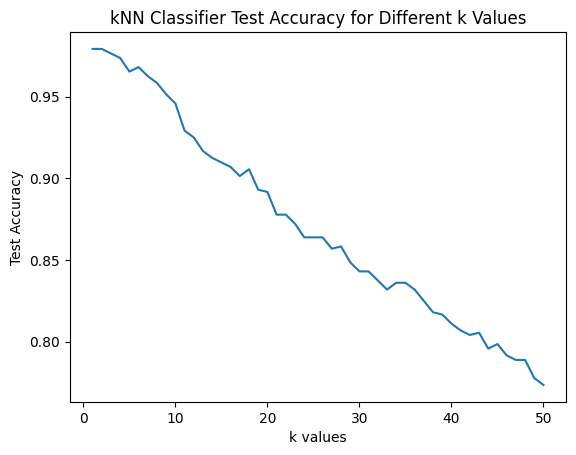

[0.9791666666666666, 0.9791666666666666, 0.9763888888888889, 0.9736111111111111, 0.9652777777777778, 0.9680555555555556, 0.9625, 0.9583333333333334, 0.9513888888888888, 0.9458333333333333, 0.9291666666666667, 0.925, 0.9166666666666666, 0.9125, 0.9097222222222222, 0.9069444444444444, 0.9013888888888889, 0.9055555555555556, 0.8930555555555556, 0.8916666666666667, 0.8777777777777778, 0.8777777777777778, 0.8722222222222222, 0.8638888888888889, 0.8638888888888889, 0.8638888888888889, 0.8569444444444444, 0.8583333333333333, 0.8486111111111111, 0.8430555555555556, 0.8430555555555556, 0.8375, 0.8319444444444445, 0.8361111111111111, 0.8361111111111111, 0.8319444444444445, 0.825, 0.8180555555555555, 0.8166666666666667, 0.8111111111111111, 0.8069444444444445, 0.8041666666666667, 0.8055555555555556, 0.7958333333333333, 0.7986111111111112, 0.7916666666666666, 0.7888888888888889, 0.7888888888888889, 0.7777777777777778, 0.7736111111111111]


In [ ]:
# def normalize(X, X_train):
#     for i in range(X.shape[1]):
#         x_min = min(X_train[:, i])
#         x_max = max(X_train[:, i])

#         f = lambda x: (x - x_min) / (x_max - x_min)
#         X[:, i] = f(X[:, i])

#     return X

# def euclidean_dist(x1,x2):
#   return np.sqrt(np.sum((x1-x2)**2))

def find_neighbors(k, X_tr, new_point):
    neighbor_arr = []
    for i in range(len(X_tr)):
        dist = np.sqrt(np.sum(np.square(X_tr[i] - new_point)))
        neighbor_arr.append([i, dist])
    neighbor_arr = sorted(neighbor_arr, key=lambda x: x[1])
    return neighbor_arr[0:k]

def kNN_predict_weighted(a_train, b_train, a_test, k):
    predictions = []
    for x_test in a_test:
        neighbors = find_neighbors(k, a_train, x_test)
        # Calculating weights based on inverse distance
        weights = [1 / neighbor[1] for neighbor in neighbors]
        # Getting the labels of neighbors
        neighbor_labels = [b_train[neighbor[0]] for neighbor in neighbors]
        # Weighted voting
        weighted_votes = Counter()
        weighted_votes.update(dict(zip(neighbor_labels, weights)))
        # Predicting the class with the maximum weighted vote
        predicted_class = weighted_votes.most_common(1)[0][0]
        predictions.append(predicted_class)

    return predictions

# k = 5
# predictions_weighted = kNN_predict_weighted(a_train, b_train, a_test, k)
# accuracy_weighted = accuracy_score(b_test, predictions_weighted)
# print("Weighted kNN Test Accuracy:", accuracy_weighted)

def normalize(X, X_train):
    for i in range(X.shape[1]):
        x_min = min(X_train[:, i])
        x_max = max(X_train[:, i])
        f = lambda x: (x - x_min) / (x_max - x_min)
        X[:, i] = f(X[:, i])

    return X

a_train_normalized = normalize(a_train.copy(), a_train)
a_test_normalized = normalize(a_test.copy(), a_train)

#Plotting test accuracy for k ranging from 1 to 50
k_values = list(range(1, 51))
accuraciez = []

for k in k_values:
    predictions = kNN_predict_weighted(a_train_normalized, b_train, a_test_normalized, k)
    accuracy = accuracy_score(b_test, predictions)
    accuraciez.append(accuracy)

plt.plot(k_values, accuraciez)
plt.xlabel('k values')
plt.ylabel('Test Accuracy')
plt.title('kNN Classifier Test Accuracy for Different k Values')
plt.show()

print(accuraciez)


## Using Sklearn for Decision Tree and K-NN


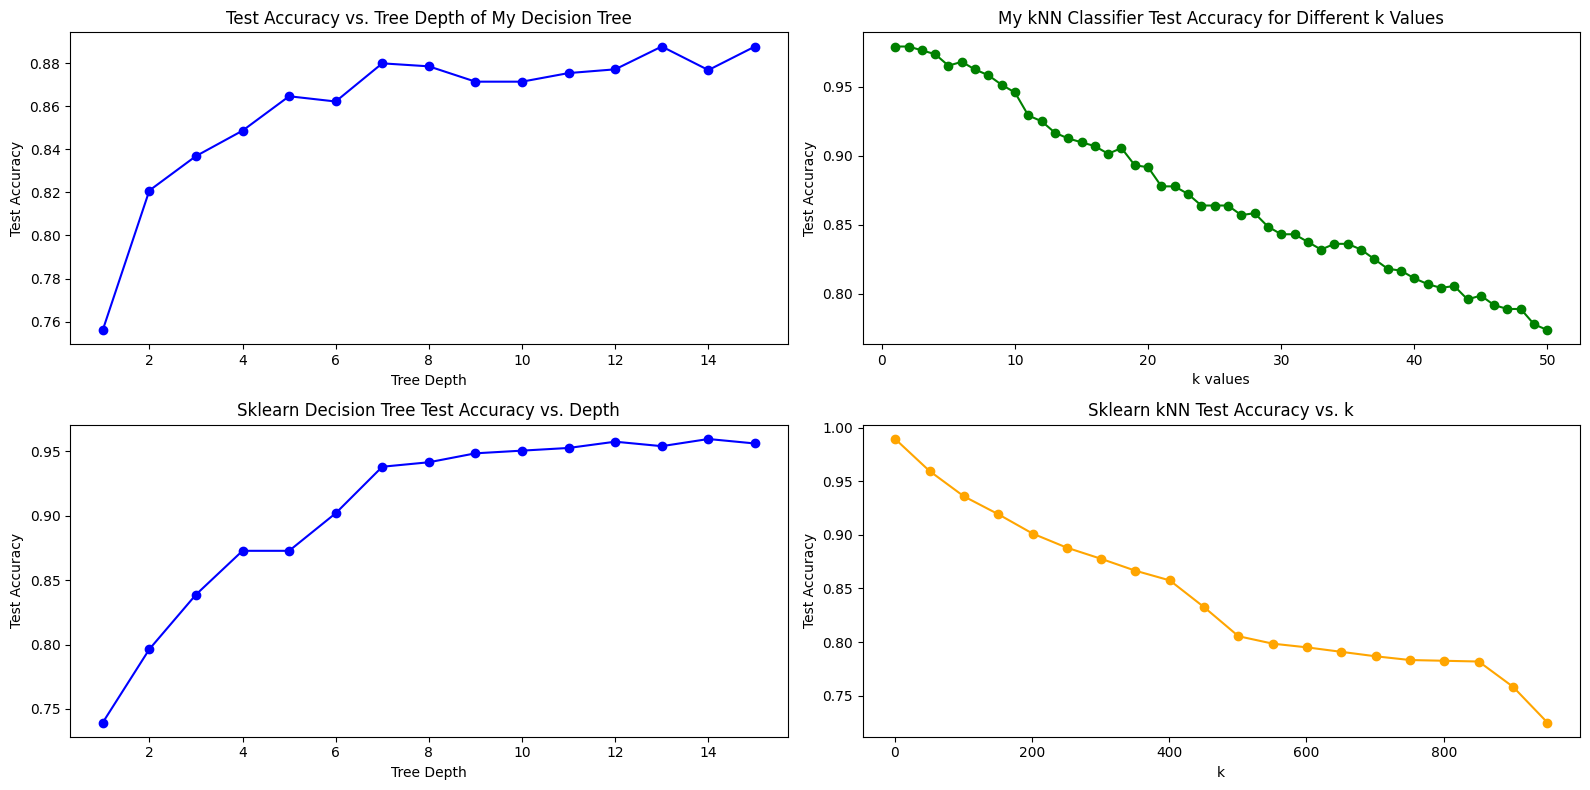

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Part 3a: Decision Tree using sklearn
X_dt = data.iloc[:, :-3]  # Using all features except 'Family', 'Genus', and 'Species'
y_dt = data['Genus']
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X_dt, y_dt, test_size=0.2, random_state=42)

depths = np.arange(1, 16)
dt_accuracies = []

for depth in depths:
    classifier_dt = DecisionTreeClassifier(max_depth=depth)
    classifier_dt.fit(X_train_dt, y_train_dt)
    y_pred_dt = classifier_dt.predict(X_test_dt)
    accuracy_dt = accuracy_score(y_test_dt, y_pred_dt)
    dt_accuracies.append(accuracy_dt)



# Part 3b: k Nearest Neighbours using sklearn
X_knn = data.iloc[:, :-3]  # Using all features except 'Family', 'Genus', and 'Species'
y_knn = data['Genus']

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.2, random_state=42)

k_value = np.arange(1, 1001, 50)  # Varying k from 1 to 1000 with a step of 50
knn_accuracies = []

for k in k_value:
    classifier_knn = KNeighborsClassifier(n_neighbors=k)
    classifier_knn.fit(X_train_knn, y_train_knn)
    y_pred_knn = classifier_knn.predict(X_test_knn)
    accuracy_knn = accuracy_score(y_test_knn, y_pred_knn)
    knn_accuracies.append(accuracy_knn)



# Part 3c: Plotting the test accuracies
plt.figure(figsize=(16, 8))

# My DT
plt.subplot(2, 2, 1)
plt.plot(depths, accuracies, marker='o', color='blue')
plt.title('Test Accuracy vs. Tree Depth of My Decision Tree')
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')

# My K-NN
plt.subplot(2, 2, 2)
plt.plot(k_values, accuraciez, marker='o', color='green')
plt.xlabel('k values')
plt.ylabel('Test Accuracy')
plt.title('My kNN Classifier Test Accuracy for Different k Values')

plt.subplot(2, 2, 3)
plt.plot(depths, dt_accuracies, marker='o', color='blue')
plt.title('Sklearn Decision Tree Test Accuracy vs. Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')

plt.subplot(2, 2, 4)
plt.plot(k_value, knn_accuracies, marker='o', color='orange')
plt.title('Sklearn kNN Test Accuracy vs. k')
plt.xlabel('k')
plt.ylabel('Test Accuracy')
plt.tight_layout()
plt.show()